<a href="https://colab.research.google.com/github/karkhotin/sentiment-analysis-on-customer-review/blob/main/Sentiment_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import re

In [ ]:
# Load Yelp polarity dataset and separate the dataset into training and test sets

dataset, info = tfds.load('yelp_polarity_reviews', with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

train_data.element_spec

2024-05-29 15:36:58.825123: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling /Users/karine/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incomplete3IO5RP/yelp_polarity_reviews…

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling /Users/karine/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incomplete3IO5RP/yelp_polarity_reviews…

Dataset yelp_polarity_reviews downloaded and prepared to /Users/karine/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
info

tfds.core.DatasetInfo(
    name='yelp_polarity_reviews',
    full_name='yelp_polarity_reviews/0.2.0',
    description="""
    Large Yelp Review Dataset.
    This is a dataset for binary sentiment classification. We provide a set of 560,000 highly polar yelp reviews for training, and 38,000 for testing. 
    ORIGIN
    The Yelp reviews dataset consists of reviews from Yelp. It is extracted
    from the Yelp Dataset Challenge 2015 data. For more information, please
    refer to http://www.yelp.com/dataset
    
    The Yelp reviews polarity dataset is constructed by
    Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset.
    It is first used as a text classification benchmark in the following paper:
    Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks
    for Text Classification. Advances in Neural Information Processing Systems 28
    (NIPS 2015).
    
    
    DESCRIPTION
    
    The Yelp reviews polarity dataset is constructed by considering stars 1 an

In [ ]:
# Print a sample review and its corresponding label from the training set

for example, label in train_data.take(1):
  print('text: \n', example.numpy(),'\n' )
  print('label: ', label.numpy())

text: 
 b"The Groovy P. and I ventured to his old stomping grounds for lunch today.  The '5 and Diner' on 16th St and Colter left me with little to ask for.  Before coming here I had a preconceived notion that 5 & Diners were dirty and nasty. Not the case at all.\\n\\nWe walk in and let the waitress know we want to sit outside (since it's so nice and they had misters).  We get two different servers bringing us stuff (talk about service) and I ask the one waitress for recommendations.  I didn't listen to her, of course, and ordered the Southwestern Burger w/ coleslaw and started with a nice stack of rings.\\n\\nThe Onion Rings were perfectly cooked.  They looked like they were prepackaged, but they were very crispy and I could actually bite through the onion without pulling the entire thing out (don't you hate that?!!!)\\n\\nThe Southwestern Burger was order Medium Rare and was cooked accordingly.  Soft, juicy, and pink with a nice crispy browned outer layer that can only be achieved on

2024-05-29 15:39:04.946095: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
# Prepare the training and test datasets: shuffle, batch, and prefetch for performance optimization

BUFFER_SIZE = 10000
BATCH_SIZE = 128
NUM_TRAIN = 100000
NUM_TEST = 20000

train_dataset = train_data.take(NUM_TRAIN).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.take(NUM_TEST).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I couldn't tell what this place was exactly from the storefront's appearance and name so curiosity got the best of me and I finally went in today.  Great concept!  The woman inside was very nice and helpful in explaining the program to me.  I bought 3 meals to take home and try:  Butternut Pork, Forbidden Chicken and Herb Roasted Chicken.  The pork and the Herb Roasted Chicken both came with the same vegetables; carrots and zucchini.  \\n\\nMy honest opinion??  Not good.  Even with BBQ sauce on the chicken and the veggies...I did not enjoy.  The chicken had a strange 'old' taste and the veggie had no detectable seasoning on them.  They were very bland and strangely, seemed to have absorbed whatever the strange 'old' taste was from the chicken.  The pork had the same weird taste and bland veggies.  I did not enjoy this either.  \\n\\nThe broccolini and rice from the Forbidden Chicken meal were ok.  But the chicken was the exact same as the Herb Roasted, same exact seasoning. 

In [ ]:
# Define a TextVectorization layer to convert text into sequences of integers

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'was', 'of', 'it',
       'for', 'in', 'is', 'that', 'my', 'we', 'this', 'with', 'but',
       'they'], dtype='<U13')

In [ ]:
# Show how text is tokenized and mapped to word identifiers

for example, label in train_dataset.take(1):
  print("Original: ", example[0].numpy())
  print('Label:',label[0].numpy())
  encoded_example = encoder(example[0].numpy())
  print("Round-trip: ", " ".join (vocab[encoded_example]))

Original:  b'Having a great store open 24/7 is great.  I have loved this F & Easy since it first opened.  The staff here is really nice and friendly and the store has always been super clean.  Everything is well organized and easy to reach.  \\nMy favorite things to buy here are the salad dressings.  Poppy seed is my personal favorite followed by the tuscan. \\nThis is also a great place to stop for a quick lunch on the go!  If you enjoy shopping for ingredients and cooking them later that day F & Easy is the place to shop!'
Label: 1
Round-trip:  having a great store open [UNK] is great i have loved this [UNK] easy since it first opened the staff here is really nice and friendly and the store has always been super clean everything is well [UNK] and easy to [UNK] [UNK] favorite things to buy here are the salad [UNK] [UNK] [UNK] is my [UNK] favorite [UNK] by the [UNK] [UNK] is also a great place to stop for a quick lunch on the go if you enjoy shopping for ingredients and [UNK] them late

In [ ]:
# Define and compile the model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-3),
              metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [ ]:
# Train the model for up to 20 epochs with early stopping to prevent overfitting

early_callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(train_dataset,
          epochs = 20,
          validation_data = test_dataset,
          callbacks = [early_callbacks]
)

Epoch 1/20
782/782 [==============================] - 492s 625ms/step - loss: 0.2850 - accuracy: 0.8754 - val_loss: 0.2480 - val_accuracy: 0.8976
Epoch 2/20
782/782 [==============================] - 464s 593ms/step - loss: 0.2261 - accuracy: 0.9058 - val_loss: 0.2154 - val_accuracy: 0.9092
Epoch 3/20
782/782 [==============================] - 499s 638ms/step - loss: 0.1975 - accuracy: 0.9184 - val_loss: 0.1970 - val_accuracy: 0.9233
Epoch 4/20
782/782 [==============================] - 542s 693ms/step - loss: 0.1742 - accuracy: 0.9292 - val_loss: 0.1974 - val_accuracy: 0.9184
Epoch 5/20
782/782 [==============================] - 539s 688ms/step - loss: 0.1604 - accuracy: 0.9351 - val_loss: 0.1828 - val_accuracy: 0.9276
Epoch 6/20
782/782 [==============================] - 542s 693ms/step - loss: 0.1506 - accuracy: 0.9386 - val_loss: 0.1784 - val_accuracy: 0.9261
Epoch 7/20
782/782 [==============================] - 560s 716ms/step - loss: 0.1413 - accuracy: 0.9431 - val_loss: 0.1783 -

In [ ]:
# Evaluate model performance

val_loss, val_acc = model.evaluate(test_dataset, verbose=0)
print("    Valid Accuracy: {:.2f}".format(val_acc*100))
print("Valid Loss: {:.5f}".format(val_loss ))

    Valid Accuracy: 92.75
Valid Loss: 0.17833


In [ ]:
# Save the trained model in TensorFlow format

model.save('LSTMmodel.tf')

INFO:tensorflow:Assets written to: LSTMmodel.tf/assets


INFO:tensorflow:Assets written to: LSTMmodel.tf/assets


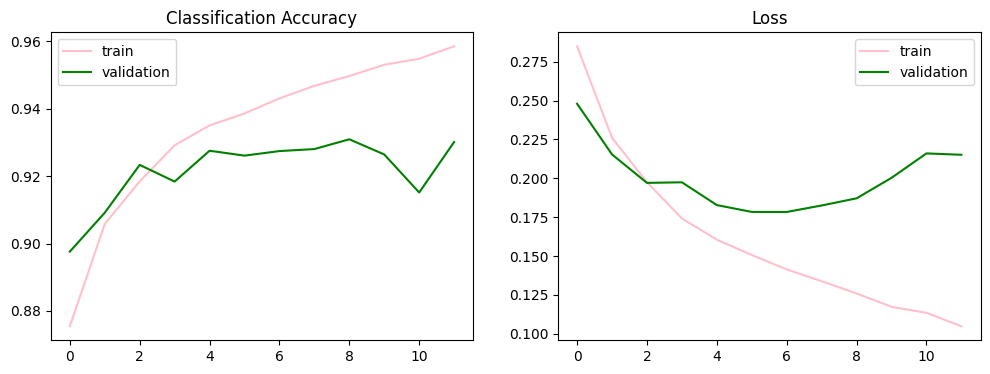

In [ ]:
# Visualize model learning progress

fig, (accuracy, loss) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 4)
accuracy.title.set_text('Classification Accuracy')
accuracy.plot(history.history['accuracy'], color='pink', label='train')
accuracy.plot(history.history['val_accuracy'], color='green', label='validation')
accuracy.legend(['train', 'validation'])
loss.title.set_text('Loss')
loss.plot(history.history['loss'], color='pink', label='train')
loss.plot(history.history['val_loss'], color='green', label='validation')
loss.legend(['train', 'validation'])
plt.show()

In [ ]:
# Predict sentiments for a batch of test reviews and compare model predictions with actual labels

class_names = ["Поганий відгук", "Хороший відгук"]

text, label = next(iter(test_dataset.take(1)))
text_array = np.array(text)
pred = model.predict(text)
pred_labels = np.round(pred).astype(int)
for j in range(6):
    print(f"Емоційне забарвлення: {class_names[label[j]]}")
    print(f"Передбачене емоційне забарвлення:{class_names[pred_labels[j][0]]}")
    print(f"Відгук:{text[j].numpy()}")
    print(f"\n")

4/4 [==============================] - 0s 32ms/step
Емоційне забарвлення: Поганий відгук
Передбачене емоційне забарвлення:Поганий відгук
Відгук:b'Was not impressed, and will not return.'


Емоційне забарвлення: Поганий відгук
Передбачене емоційне забарвлення:Поганий відгук
Відгук:b'I went in to purchase overalls and was treated so rudely I had to walk out even though he had the item I wanted.  I will never step foot in this placec of business again.'


Емоційне забарвлення: Поганий відгук
Передбачене емоційне забарвлення:Поганий відгук
Відгук:b'This place really is horrible... Every time I wind up getting convinced to go here, I always walk out feeling like my pocket has been picked. The food isn\'t \\""bad,\\"" but at roughly $25-$30 per person, there are SO many better places to eat. To hell with Olive Garden.\\n\\nAnd this particular one has the worst-smelling parking lot in Las Vegas... every time I drive by (to go to B.J.\'s nearby, which is a thousand times better), it smells lik

In [ ]:
# Test the model on custom reviews

string_tensor = tf.constant(["I was very disappointed with my visit.",
    "The service here was terrible - the waiter was rude and inattentive. The food was mediocre at best, and definitely not worth the price.",
    "This place is totally lit!!!The food was off the chain and the vibes were on point. Staff was super chill too. Definitely my new fave spot!",
    "I had high hopes for this restaurant, but it fell short in every way. I won't be coming back!",
    "SOOOO PRETTY PLACE...",
    "Such a dope place! The eats were killer and the whole atmosphere was super cool."
    ])

text_array = np.array(string_tensor)
prediction = model.predict(text_array)
pred_labels = np.round(pred).astype(int)
for j in range(len(string_tensor)):
    print(f"Передбачене емоційне забарвлення:{class_names[pred_labels[j][0]]}")
    print(f"Відгук:{string_tensor[j].numpy()}")
    print(f"\n")

1/1 [==============================] - 0s 11ms/step
Передбачене емоційне забарвлення:Поганий відгук
Відгук:b'I was very disappointed with my visit.'


Передбачене емоційне забарвлення:Поганий відгук
Відгук:b'The service here was terrible - the waiter was rude and inattentive. The food was mediocre at best, and definitely not worth the price.'


Передбачене емоційне забарвлення:Хороший відгук
Відгук:b'This place is totally lit!!!The food was off the chain and the vibes were on point. Staff was super chill too. Definitely my new fave spot!'


Передбачене емоційне забарвлення:Поганий відгук
Відгук:b"I had high hopes for this restaurant, but it fell short in every way. I won't be coming back!"


Передбачене емоційне забарвлення:Хороший відгук
Відгук:b'SOOOO PRETTY PLACE...'


Передбачене емоційне забарвлення:Хороший відгук
Відгук:b'Such a dope place! The eats were killer and the whole atmosphere was super cool.'


